
> ⚠️ **Warning:** This notebook file is paired to a .py file with the same name, such that we can cleanly import the functionality from other notebooks. This is done using the facilities of the jupytext package. The cells in this notebook that are only meant as "demonstration" are marked with the cell tag "active-ipynb", which causes the jupytext synchronization command to ignore these when syncing to the .py file. This is our current way of doing "literate programming" with jupyter notebooks.

In [1]:
%load_ext autoreload
%autoreload 2

## Threshold heuristic

In [ ]:
from single.mdp import SingleScheduleEnv, HorizonObservationWrapper

import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

from dataclasses import dataclass


def _threshold_policy(obs, tau, switch):
    if np.count_nonzero(obs['h_lengths']) == 1: # only one route to go
        return np.nanargmax(obs['h_lengths'])

    # we only need the lower bound of the first unscheduled on each route
    # so put these in a 1-d array, with Nan for routes that are done
    beta = obs['horizon'][:, 0]
    beta[obs['h_lengths'] == 0] = np.nan

    r_min  = np.nanargmin(beta)
    beta_min = beta[r_min]
    if beta_min <= tau:
        return r_min
    else:
        # pick argmin{\beta_r : \beta_r >= c(s_t) + \sigma-\rho},
        # where c(s_t) is "current time"
        # and \sigma-\rho is "switch"
        beta[beta < switch] = np.nan
        return np.nanargmin(beta)

def _execute_treshold_policy(s, tau):
    # execute the threshold policy $\pi_\tau$ on instance s
    env = SingleScheduleEnv(instance=s)
    env = HorizonObservationWrapper(env)
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        route = _threshold_policy(obs, tau, env.unwrapped.switch)
        obs, reward, done, *_ = env.step(route)
        total_reward += reward
    return total_reward


@dataclass
class ThresholdGridSearch:
    tau_range: np.ndarray

    def train(self, gen, N_train=500, **options):
        # generate training data
        instances = [gen() for _ in range(N_train)]

        # do simple grid search to find best threshold parameter
        tau_range_str = ", ".join(f"{tau:.2f}" for tau in self.tau_range)
        print(f"searching tau over {tau_range_str}")
        self.tau_scores = []
        for tau in self.tau_range:
            scores = [_execute_treshold_policy(s, tau) for s in instances]
            self.tau_scores.append(sum(scores) / N_train)
        self.tau_score = np.max(self.tau_scores)
        self.tau = self.tau_range[np.argmax(self.tau_scores)]

    def eval(self, gen):
        instance = gen()
        return -_execute_treshold_policy(instance, self.tau)

    def report(self):
        plt.plot(self.tau, self.tau_score, 'ro')
        plt.plot(self.tau_range, self.tau_scores, '.-')
        plt.xlabel(r'threshold tau')
        plt.ylabel(r'average reward')


@dataclass
class ThresholdBrentSearch:
    def __init__(self, **kwargs):
        self.options = kwargs
    
    def train(self, gen, **options):
        # generate training data
        N_train = options.pop('N_train', 500)
        instances = [gen() for _ in range(N_train)]

        # Brent's method
        def loss(tau):
            scores = [_execute_treshold_policy(s, tau) for s in instances]
            return -sum(scores) / N_train

        self.res = minimize_scalar(loss, bounds=(0, 2), options=self.options)
        self.tau = self.res.x

    def eval(self, gen):
        instance = gen()
        return -_execute_treshold_policy(instance, self.tau)

    def report(self):
        plt.plot(self.res.x, -self.res.fun, 'ro')

Define some problem distribution.

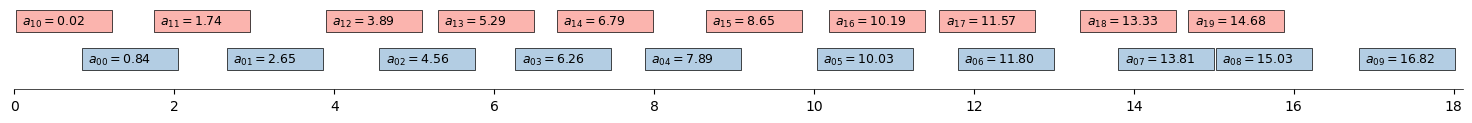

In [15]:
from single.instances import generate_instance, uniform, bimodal_exponential
import matplotlib.pyplot as plt

F = uniform()
# F = bimodal_exponential(p=0.2, s1=0.01, s2=2.0)
gen = lambda: generate_instance(F, R=2, n=[10, 10])

gen().visualize()

Find the best threshold parameter and plot the score for all candidates.

searching tau over 0.00, 0.07, 0.13, 0.20, 0.27, 0.33, 0.40, 0.47, 0.53, 0.60
best parameter grid: 0.26666666666666666


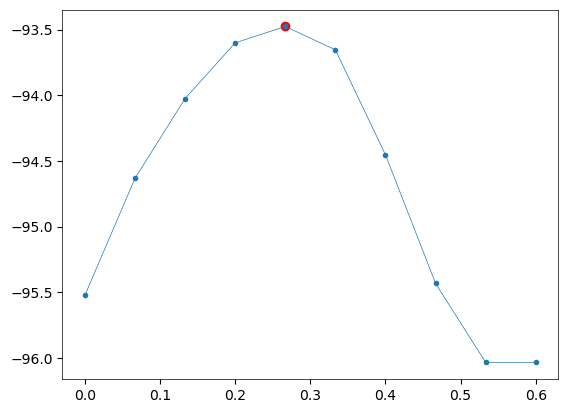

In [16]:
grid = ThresholdGridSearch(np.linspace(0, 0.6, 10))
grid_scores = grid.train(gen)
print(f"best parameter grid: {grid.tau}")
grid.report()

# brent = ThresholdBrentSearch()
# brent_res = brent.train(gen)
# print(f"best parameter brent: {brent.tau}")
# brent.report()